In [1]:
import yfinance as yf

# Fetch stock data for Apple (AAPL)
data = yf.download('AAPL', start='2010-01-01', end='2024-01-01')

# Save as CSV
data.to_csv('stock_data.csv')

print("Dataset Downloaded Successfully!")


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Dataset Downloaded Successfully!


[*********************100%***********************]  1 of 1 completed
<ipython-input-4-a1f6b121ff1a>:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Close'] = data['Close'].fillna(method='ffill')


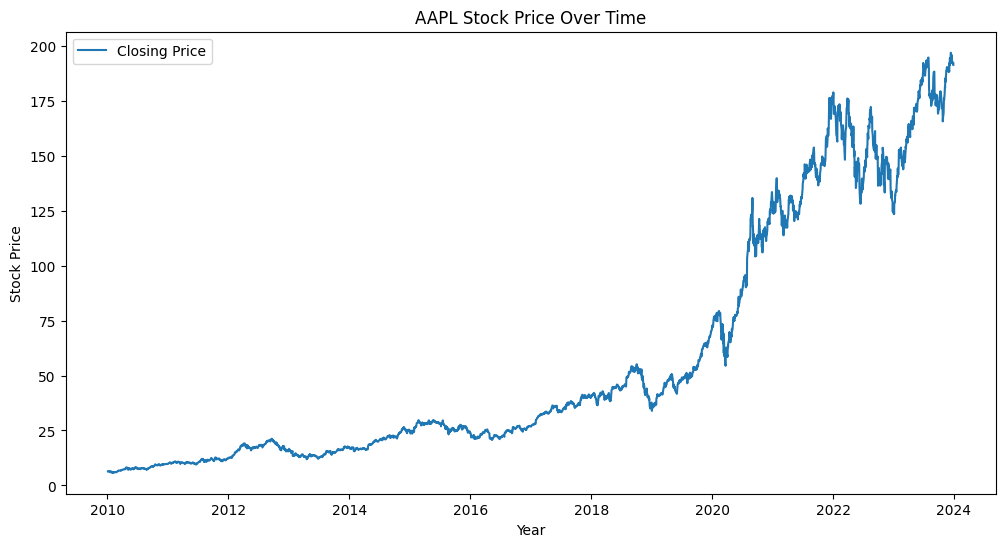

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


87/87 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - loss: 0.0056 - val_loss: 0.0012
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - loss: 4.9601e-04 - val_loss: 9.2077e-04
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - loss: 4.3727e-04 - val_loss: 8.8033e-04
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 4.6311e-04 - val_loss: 9.4333e-04
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 5.8980e-04 - val_loss: 0.0012
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - loss: 4.0645e-04 - val_loss: 7.8522e-04
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 3.6946e-04 - val_loss: 0.0023
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 3.6328e-04 - val_loss: 9.1865e-04
Epoch 9/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 3.2563e-04 - val_loss: 0.0019
Epoch 10/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 4.2062e-04 - val_loss: 0.0023
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


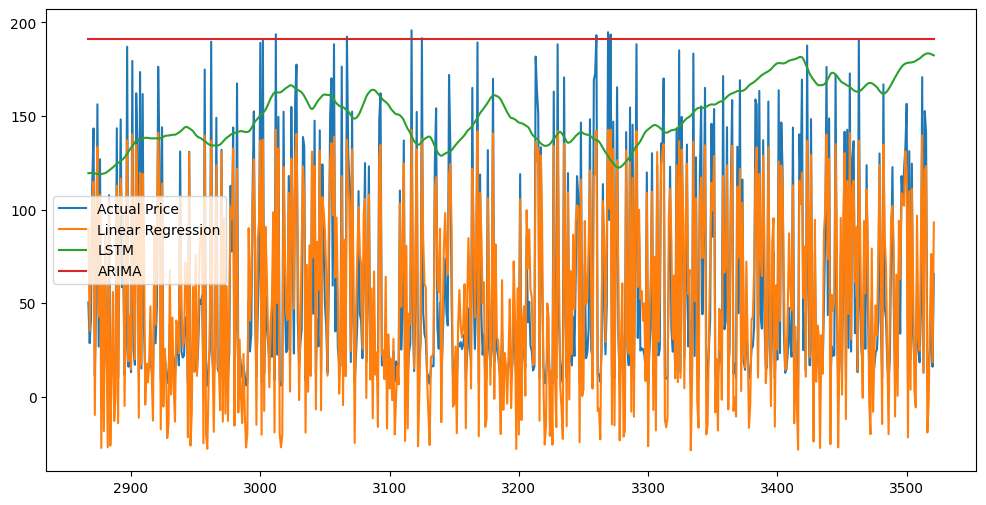

Stock Price Prediction Completed!


In [4]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Step 1: Load Stock Data
ticker = 'AAPL'  # Change this to any stock symbol
data = yf.download(ticker, start='2010-01-01', end='2024-01-01')
data.to_csv('stock_data.csv')

# Step 2: Data Preprocessing
data['Date'] = data.index
data.reset_index(drop=True, inplace=True)
data['Close'] = data['Close'].fillna(method='ffill')

# Step 3: Data Visualization
plt.figure(figsize=(12,6))
sns.lineplot(data=data, x='Date', y=data['Close'].values.flatten(), label='Closing Price')

plt.title(f'{ticker} Stock Price Over Time')
plt.xlabel('Year')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Step 4: Prepare Data for ML Models
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(data[['Close']])
train_size = int(len(data) * 0.8)
train_data, test_data = data_scaled[:train_size], data_scaled[train_size:]

# Prepare LSTM data
def create_sequences(data, time_steps=50):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_data)
X_test, y_test = create_sequences(test_data)

# Step 5: Train Linear Regression Model
X_lr = np.arange(len(data)).reshape(-1,1)
y_lr = data['Close'].values
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_lr, y_lr, test_size=0.2, random_state=42)
model_lr = LinearRegression()
model_lr.fit(X_train_lr, y_train_lr)
y_pred_lr = model_lr.predict(X_test_lr)

# Step 6: Train LSTM Model
model_lstm = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=1)
])
model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Step 7: Train ARIMA Model
model_arima = ARIMA(data['Close'], order=(5,1,0))
model_arima_fit = model_arima.fit()

# Step 8: Predictions
pred_lr = model_lr.predict(X_test_lr)
pred_lstm = model_lstm.predict(X_test)
pred_arima = model_arima_fit.forecast(steps=len(test_data))

# Step 9: Plot Predictions
plt.figure(figsize=(12,6))
# Adjust x-axis data to match the length of LSTM predictions
plt.plot(data.index[-len(pred_lstm):], y_test_lr[-len(pred_lstm):], label='Actual Price') # Updated x-axis range
plt.plot(data.index[-len(pred_lstm):], pred_lr[-len(pred_lstm):], label='Linear Regression') # Updated x-axis range
plt.plot(data.index[-len(pred_lstm):], scaler.inverse_transform(pred_lstm.reshape(-1,1)), label='LSTM') # Updated x-axis range
plt.plot(data.index[-len(pred_lstm):], pred_arima[-len(pred_lstm):], label='ARIMA') # Updated x-axis range
plt.legend()
plt.show()

print("Stock Price Prediction Completed!")
